<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Classification_LDA_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [0]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

#Load data

In [21]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
public_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
PA_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
public_labels = df_train.Histology

In [0]:
PA_labels = df_test.Histology

#Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(public_data, public_labels, test_size=13, stratify=public_labels, random_state=1)

In [33]:
X_train.shape

(118, 107)

#Vettorizzare i label

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(y_train)
test_labels_encoded = encoder.transform(y_test)

#Z score dei dati

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data_stand = scaler.fit_transform(X_train)
test_data_stand = scaler.transform(X_test)

#LDA

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [0]:
lda = LinearDiscriminantAnalysis(n_components=3)

In [38]:
train_data_stand_lda = lda.fit_transform(train_data_stand, train_labels_encoded)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(107, 3 - 1) = 2 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [39]:
train_data_stand_lda.shape

(118, 2)

In [0]:
test_data_stand_lda = lda.transform(test_data_stand)

#Z-score dopo LDA

In [0]:
from sklearn.preprocessing import StandardScaler
scaler_2 = StandardScaler()
train_data_stand_lda = scaler_2.fit_transform(train_data_stand_lda)
test_data_stand_lda = scaler_2.transform(test_data_stand_lda)

#Built classification algorithm: Nearest Neighbors

In [0]:
from sklearn.neighbors import KNeighborsClassifier


In [0]:
neigh = KNeighborsClassifier(n_neighbors=5) 

In [44]:
neigh.fit(train_data_stand_lda, train_labels_encoded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [45]:
neigh.score(test_data_stand_lda, test_labels_encoded)

0.3076923076923077

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = neigh.predict(test_data_stand_lda)

cm = confusion_matrix(test_labels_encoded, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(test_labels_encoded, y_pred)))

[[1 1 0]
 [2 2 2]
 [2 2 1]]
Accuracy0.3076923076923077


Text(0.5, 1.0, 'Confusion matrix Nearest Neighbors')

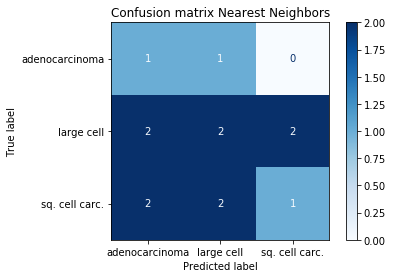

In [51]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(neigh, test_data_stand_lda, test_labels_encoded,
                                 display_labels=['adenocarcinoma', 'large cell', 'sq. cell carc.'], 
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Confusion matrix Nearest Neighbors')

##Cross_validation (stratified) results

In [0]:
from sklearn.model_selection import StratifiedKFold

In [53]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
skf.get_n_splits(X_train, train_labels_encoded)

3

In [0]:
X_train_np = X_train.to_numpy()

In [55]:
results=[]
for train_index, val_index in skf.split(X_train_np, train_labels_encoded):
 
  partial_train_data = np.array([X_train_np[i] for i in train_index])
  partial_train_targets = np.array([train_labels_encoded[i] for i in train_index])
  
  val_data = np.array([X_train_np[i] for i in val_index])
  val_targets = np.array([train_labels_encoded[i] for i in val_index])

  lda.fit(partial_train_data, partial_train_targets)
  outVal = lda.score(val_data, val_targets)
  results.append(outVal)
print('Score: ' + str(results))

LDA results: 
Score: [0.3, 0.3333333333333333, 0.4358974358974359]


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(107, 3 - 1) = 2 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(107, 3 - 1) = 2 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components

In [0]:
results

[0.3, 0.3333333333333333, 0.4358974358974359]

In [0]:
a=np.array(results)

In [0]:
a.mean()

0.3564102564102564

#Built classification algorithm: SVM

In [0]:
from sklearn.svm import SVC

In [0]:
clf = SVC(gamma='auto', kernel='linear', C=0.1)

In [0]:
clf.fit(train_data_stand_lda, y_train)

In [0]:
clf.score(val_data_stand_lda, y_val)

In [0]:
clf.score(test_data_stand_lda, PA_labels)

In [0]:
y_pred

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = clf.predict(val_data_stand_lda)

cm = confusion_matrix(y_val, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_val, y_pred)))

In [0]:
#matrice di confusione


fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
            ax.text(x=j,  y=i, s=cm[i, j],  va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()


In [0]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(clf, val_data_stand_lda, y_val,
                                 display_labels=['adenocarcinoma', 'large cell', 'sq. cell carc.'], 
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Confusion matrix SVM')

##Cross Validation

In [0]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, train_data_stand_lda, y_train, cv=3)
scores